# Set Up

Imports

In [53]:
# general imports
import argparse
import sys
import pandas as pd
import matplotlib.pyplot as plt

# imports for master dict
import os
import json
import numpy as np

# imports for placesCNN()
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
from PIL import Image

Master Dict Class

In [54]:
#----------------------------------------------------------------------
# MASTER_DICT
# get all the important information you need
# that does not require opening the blender file
def getMasterDict(dataset_path, scene_id):
    # Conversion_dicts
    # dicts to convert between object-indicies to solve_state_json_names and blender_names
    indexToBlender = {}
    blenderToIndex = {}
    jsonToBlender = {}
    blenderToJson = {}

    # get all object indecies from the objectsegmentation array
    # frames/ObjectSegmentation/camera_0/ObjectSegmentation_0_0_0048_0.npy
    obj_seg_path = os.path.join( dataset_path, scene_id, "frames", "ObjectSegmentation", "camera_0", "ObjectSegmentation_0_0_0048_0.npy")
    obj_seg_arr = np.load(obj_seg_path)
    obj_seg_set = set( obj_seg_arr.flatten() )
    if 0 in obj_seg_set:
        obj_seg_set.remove(0) # remove 0 from set

    # go through objects.json, find all matching objects, and update the conversion_dicts
    obj_json_path = os.path.join( dataset_path, scene_id, "frames", "Objects", "camera_0", "Objects_0_0_0048_0.json")
    with open( obj_json_path, "r") as obj_json_file:
        obj_json_map = json.load(obj_json_file)
    
    for key, meta in obj_json_map.items():
        blender_obj_name = key
        obj_index = meta["object_index"]
        if obj_index in obj_seg_set:
            indexToBlender[obj_index] = blender_obj_name
            blenderToIndex[blender_obj_name] = obj_index
    
    # print("PRE-FILTERING: Blender-Index Conversions: ", "Number of enteries: ", len(indexToBlender))
    # print("IndexToBlender: ", indexToBlender)
    # print("BlenderToIndex: ", blenderToIndex)
    # print("\n", flush = True)

    # filter out unwanted objects
    filtered_list = [] # a list of (obj, index) to be removed
    filter_set = {"kitchen_0", "living-room_0", "dining-room_0", "bedroom_0", "bathroom_0"}
    for blender_obj_name, obj_index in blenderToIndex.items():
        for filter_item in filter_set:
            if filter_item in blender_obj_name:
                filtered_list.append( (blender_obj_name, obj_index) )
                break

    for blender_obj_name, obj_index in filtered_list:
        blenderToIndex.pop(blender_obj_name)
        indexToBlender.pop(obj_index)

    # populate dicts for blender_obj_names to and from solve_state_json_obj_names
    solve_state_json_path = os.path.join( dataset_path, scene_id, "coarse", "solve_state.json" )
    with open(solve_state_json_path, "r") as solve_state_json_file:
        solve_state_json_map = json.load(solve_state_json_file)
        solve_state_json_map = solve_state_json_map["objs"] # unpack objs
    for key, meta in solve_state_json_map.items():
        if meta['obj'] in blenderToIndex:
            json_obj_name = key
            blender_obj_name = meta['obj']
            blenderToJson[blender_obj_name] = json_obj_name
            jsonToBlender[json_obj_name] = blender_obj_name
    # json has less objects than index and blender
    for obj_blender_name in blenderToIndex.keys():
        if obj_blender_name not in blenderToJson:
            blenderToJson[obj_blender_name] = None

    # print("Filter: ", "removedCount:", len(filtered_list), "remainingCount", len(blenderToIndex))
    # print("removed: ", filtered_list)
    # print("remaining: ", blenderToIndex.keys())
    # print("POST-FILTER: (index: blender : json)")
    # for obj_index, blender_obj_name in indexToBlender.items():
    #     print(f"{obj_index}: {blender_obj_name} : {blenderToJson[blender_obj_name]}")
    # print("\n", flush = True)


    # for each object (blender_name), map it to a list of 'dependents' that depend on it
    # i.e. table should map to all the plates on the table
    # use blender names for objects
    dependents_map = {}

    for root in blenderToIndex.keys():
        # run bfs
        queue = [ root ]
        dependents = set() # fill it with all objects connected to parent
        visited = { root } # technically not needed since you can only depend on one thing and there are no cycles
        while queue:
            # process current object by adding it to dependents set
            curr_obj_blender = queue.pop(0)
            if curr_obj_blender != root: # don't include the root as a dependent
                dependents.add( curr_obj_blender )

            # put all eligible children in the queue

            # Objects.json condition...
            # accept children of curr_obj_blender
            for child_index in obj_json_map[curr_obj_blender]["children"]:
                if child_index in indexToBlender and indexToBlender[child_index] not in visited:
                    visited.add( indexToBlender[child_index] )
                    queue.append( indexToBlender[child_index] )
            
            # Solve_state.json condition...
            if not blenderToJson[curr_obj_blender]: # some blender objs are not listed in obj
                continue
            for key in jsonToBlender.keys():
                if jsonToBlender[key] in visited:
                    continue
                for rel in solve_state_json_map[key]["relations"]:
                    target_name = rel["target_name"]
                    relation_type = rel["relation"]["relation_type"]
                    child_tags = rel["relation"]["child_tags"]
                    if (target_name == blenderToJson[curr_obj_blender]
                            and relation_type == "StableAgainst"
                            and "Subpart(bottom)" in child_tags
                    ):
                        visited.add( jsonToBlender[key] )
                        queue.append( jsonToBlender[key] )
        dependents_map[ root ] = dependents

    # print out pretty formatted dependents_map
    # def set_default(obj):
    #     if isinstance(obj, set):
    #         return list(obj)
    #     raise TypeError
    # pretty_print = json.dumps( dependents_map, indent=2, default=set_default )
    # print( "Dependents_map: ", pretty_print )

    # categorize objects by groups
    # create maps from groups to objects and vice versa
    groupToObjects = {}
    objectToGroup = {}
    for blender_obj_name in blenderToIndex.keys():
        index = blender_obj_name.find("Factory")
        if index != -1:
            group_name = blender_obj_name[:index]
        else:
            group_name = blender_obj_name
        objectToGroup[blender_obj_name] = group_name
        if group_name in groupToObjects:
            groupToObjects[group_name].append(blender_obj_name)
        else:
            groupToObjects[group_name] = [ blender_obj_name ]
    
    masterDict = {
        # our 4 name conversion dictionaries
        "indexToBlender": indexToBlender,
        "blenderToIndex": blenderToIndex,
        "jsonToBlender": jsonToBlender,
        "blenderToJson": blenderToJson,

        # relational dependencies
        "dependents_map": dependents_map,
        "groupToObjects": groupToObjects,
        "objectToGroup": objectToGroup,

        "obj_seg_arr": obj_seg_arr, #from objectSegmentation.npy
    }
    return masterDict
#----------------------------------------------------------------------

PlacesCNN Class

In [55]:
#----------------------------------------------------------------------
# PLACES365_RESNET
class placesCNN():
    def __init__(self):
        """
        saves model, centre_crop, and classes as instance variables
        model and centre_crop are used in predict()
        classes[i] is the class name of the ith class
        """
        # th architecture to use
        arch = 'resnet18'

        # load the pre-trained weights
        model_file = '%s_places365.pth.tar' % arch
        if not os.access(model_file, os.W_OK):
            weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
            os.system('wget ' + weight_url)

        model = models.__dict__[arch](num_classes=365)
        checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
        state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
        model.load_state_dict(state_dict)
        model.eval()


        # load the image transformer
        centre_crop = trn.Compose([
                trn.Resize((256,256)),
                trn.CenterCrop(224),
                trn.ToTensor(),
                trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # load the class label
        file_name = 'categories_places365.txt'
        if not os.access(file_name, os.W_OK):
            synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
            os.system('wget ' + synset_url)
        classes = list()
        with open(file_name) as class_file:
            for line in class_file:
                classes.append(line.strip().split(' ')[0][3:])
        classes = tuple(classes)

        # variables we care about
        self.model= model
        self.centre_crop = centre_crop
        self.classes = classes
    
    def predict(self, img_path):
        """
        Returns h_x, probs, idx
        h_x[i] is model's prediction for class i
        probs[i] is the model's prediction for the ith highest class
        idx[i] is the class index corresponding to the ith highest class
        """
        img = Image.open(img_path).convert("RGB")
        input_img = V(self.centre_crop(img).unsqueeze(0)) # preprocess & batchify

        # forward pass
        logit = self.model(input_img)
        h_x = F.softmax(logit, 1).data.squeeze()
        probs, idx = h_x.sort(0, True)

        return h_x, probs, idx
#----------------------------------------------------------------------

# Count Stuff

In [50]:
# get each of the raw data csv files
raw_data_df_arr = []
data_folder = "/n/fs/obj-cv/experiment_project/experiments/objRemovalExp/dataFolder"
for ground_data in sorted( os.listdir(data_folder) ):
    df = pd.read_csv( os.path.join(data_folder, ground_data, "rawData.csv") )
    raw_data_df_arr.append(df)

# get the dataset paths as well
dataset_path_arr = []
dataset_folder = "/n/fs/obj-cv/infinigen_project/savedDatasets"
for ground_data in sorted( os.listdir(dataset_folder) ):
    dataset_path_arr.append( os.path.join( dataset_folder, ground_data) )

ground_arr = [
    45, # bathroom
    52, # bedroom
    121, # diningroom
    203, # kitchen
    215 # livingroom
]

CNN = placesCNN()


print(dataset_path_arr)
for df in raw_data_df_arr:
    print( df.loc[0]["groundName"] )

['/n/fs/obj-cv/infinigen_project/savedDatasets/bathroom97', '/n/fs/obj-cv/infinigen_project/savedDatasets/bedroom96', '/n/fs/obj-cv/infinigen_project/savedDatasets/diningRoom99', '/n/fs/obj-cv/infinigen_project/savedDatasets/kitchenDataset94', '/n/fs/obj-cv/infinigen_project/savedDatasets/livingRoom99']
bathroom
bedroom
dining_room
kitchen
living_room


/tmp/ipykernel_391849/1523398849.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)


In [51]:
# Count all scenes with a kitchenSpace and an Oven and list all objects applicable on the kitchenSpace
df = raw_data_df_arr[3]
dataset_path = dataset_path_arr[3]
ground_id = ground_arr[3]
ground_name = CNN.classes[ ground_id ]

data_arr = []

# go through each scene
for scene_id in sorted( os.listdir( dataset_path) ):
    if not os.path.isdir( os.path.join(dataset_path, scene_id) ):
        continue
    mDct = getMasterDict( dataset_path, scene_id )
    # Reference
    # masterDict = {
    #     # our 4 name conversion dictionaries
    #     "indexToBlender": indexToBlender,
    #     "blenderToIndex": blenderToIndex,
    #     "jsonToBlender": jsonToBlender,
    #     "blenderToJson": blenderToJson,

    #     # relational dependencies
    #     "dependents_map": dependents_map,
    #     "groupToObjects": groupToObjects,
    #     "objectToGroup": objectToGroup,

    #     "obj_seg_arr": obj_seg_arr, #from objectSegmentation.npy
    # }
    if "KitchenSpace" not in mDct["groupToObjects"] or "Oven" not in mDct["groupToObjects"]:
        continue
    
    kitchenSpace_obj = mDct["groupToObjects"]["KitchenSpace"][0]
    oven_obj = mDct["groupToObjects"]["Oven"][0]

    for dependent in mDct["dependents_map"][kitchenSpace_obj]:
        row_dict = {
            "sceneId": scene_id,
            "source": kitchenSpace_obj,
            "dest": oven_obj,
            "smallObject": dependent,
            "sourceGroup": "KitchenSpace",
            "destGroup": "Oven",
            "smallObjectGroup": mDct["objectToGroup"][dependent],
            "groundId": ground_id,
            "groundName": ground_name
        }
        row_dict["smallObject"] = dependent
        row_dict["smallObjectGroup"] = mDct["objectToGroup"][dependent]
        data_arr.append(row_dict)
        print(len(data_arr))
        print(data_arr)


1
[{'sceneId': '1420624e', 'source': 'KitchenSpaceFactory(513529).spawn_asset(9976799)', 'dest': 'OvenFactory(2033892).spawn_asset(8574077)', 'smallObject': 'JarFactory(4380497).spawn_asset(6313724)', 'sourceGroup': 'KitchenSpace', 'destGroup': 'Oven', 'smallObjectGroup': 'Jar', 'groundId': 203, 'groundName': 'kitchen'}]
2
[{'sceneId': '1420624e', 'source': 'KitchenSpaceFactory(513529).spawn_asset(9976799)', 'dest': 'OvenFactory(2033892).spawn_asset(8574077)', 'smallObject': 'JarFactory(4380497).spawn_asset(6313724)', 'sourceGroup': 'KitchenSpace', 'destGroup': 'Oven', 'smallObjectGroup': 'Jar', 'groundId': 203, 'groundName': 'kitchen'}, {'sceneId': '1420624e', 'source': 'KitchenSpaceFactory(513529).spawn_asset(9976799)', 'dest': 'OvenFactory(2033892).spawn_asset(8574077)', 'smallObject': 'MicrowaveFactory(1849906).spawn_asset(842634)', 'sourceGroup': 'KitchenSpace', 'destGroup': 'Oven', 'smallObjectGroup': 'Microwave', 'groundId': 203, 'groundName': 'kitchen'}]
3
[{'sceneId': '1420624

In [52]:
data_arr

[{'sceneId': '1420624e',
  'source': 'KitchenSpaceFactory(513529).spawn_asset(9976799)',
  'dest': 'OvenFactory(2033892).spawn_asset(8574077)',
  'smallObject': 'JarFactory(4380497).spawn_asset(6313724)',
  'sourceGroup': 'KitchenSpace',
  'destGroup': 'Oven',
  'smallObjectGroup': 'Jar',
  'groundId': 203,
  'groundName': 'kitchen'},
 {'sceneId': '1420624e',
  'source': 'KitchenSpaceFactory(513529).spawn_asset(9976799)',
  'dest': 'OvenFactory(2033892).spawn_asset(8574077)',
  'smallObject': 'MicrowaveFactory(1849906).spawn_asset(842634)',
  'sourceGroup': 'KitchenSpace',
  'destGroup': 'Oven',
  'smallObjectGroup': 'Microwave',
  'groundId': 203,
  'groundName': 'kitchen'},
 {'sceneId': '1420624e',
  'source': 'KitchenSpaceFactory(513529).spawn_asset(9976799)',
  'dest': 'OvenFactory(2033892).spawn_asset(8574077)',
  'smallObject': 'TapFactory(9203000).spawn_asset(807853)',
  'sourceGroup': 'KitchenSpace',
  'destGroup': 'Oven',
  'smallObjectGroup': 'Tap',
  'groundId': 203,
  'grou

In [53]:
df = pd.DataFrame( data_arr )
df.head()

with open(os.path.join("/n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp", "rawData.csv"), "w") as file:
    file.write(df.to_csv())

In [54]:
# Filter out non important groups
# Big Objects: KitchenSpace, Oven, LargeShelf
# Small Objects: Pan, Cup, Microwave, Bowl, Wineglass, Pot
# Not moveable: Sink, LiteDoor

df = pd.read_csv( "/n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp/KitchenSpaceToOven.csv", index_col=0 )
filter_groups = [ "Sink", "Tap" ]
df = df[ ~df["smallObjectGroup"].isin(filter_groups) ]
df = df.reset_index(drop=True)
print(df)
with open(os.path.join("/n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp", "rawData.csv"), "w") as file:
    file.write(df.to_csv())

     sceneId                                             source  \
0   1420624e   KitchenSpaceFactory(513529).spawn_asset(9976799)   
1   1420624e   KitchenSpaceFactory(513529).spawn_asset(9976799)   
2   19dd0dd5   KitchenSpaceFactory(592551).spawn_asset(2906036)   
3   33f84adc  KitchenSpaceFactory(5533514).spawn_asset(5518485)   
4   3fceb0b8  KitchenSpaceFactory(6972066).spawn_asset(6938622)   
5   46036342  KitchenSpaceFactory(7562496).spawn_asset(9278629)   
6   46036342  KitchenSpaceFactory(7562496).spawn_asset(9278629)   
7   47f5f3ec  KitchenSpaceFactory(5367637).spawn_asset(8248550)   
8   47f5f3ec  KitchenSpaceFactory(5367637).spawn_asset(8248550)   
9   4d4c47b3  KitchenSpaceFactory(8162481).spawn_asset(9836638)   
10   4e87bd2  KitchenSpaceFactory(7720005).spawn_asset(7374985)   
11  563e56d9  KitchenSpaceFactory(7610244).spawn_asset(7205807)   
12  563e56d9  KitchenSpaceFactory(7610244).spawn_asset(7205807)   
13  6f3112cd  KitchenSpaceFactory(6180001).spawn_asset(2282117

In [55]:
# get the normal scores for the original images from raw_dfs

old_df = raw_data_df_arr[3]
old_df = old_df.groupby( "sceneId" ).agg( 
    normGroundProb = ('normGroundProb', 'first'),
    normOrigProb = ('normOrigProb', 'first'),
    normOrigIdx = ('normOrigIdx', 'first')
)

normGroundProb_arr = []
normOrigProb_arr = []
normOrigIdx_arr = []

for scene_id in list(df["sceneId"]):
    normGroundProb_arr.append( old_df.loc[scene_id]["normGroundProb"] )
    normOrigProb_arr.append( old_df.loc[scene_id]["normOrigProb"] )
    normOrigIdx_arr.append( int(old_df.loc[scene_id]["normOrigIdx"]) )

df[ "normGroundProb" ] = normGroundProb_arr
df[ "normOrigProb" ] = normOrigProb_arr
df[ "normOrigIdx" ] = normOrigIdx_arr
df



,sceneId,source,dest,smallObject,sourceGroup,destGroup,smallObjectGroup,groundId,groundName,normGroundProb,normOrigProb,normOrigIdx
0,1420624e,KitchenSpaceFactory(513529).spawn_asset(9976799),OvenFactory(2033892).spawn_asset(8574077),MicrowaveFactory(1849906).spawn_asset(842634),KitchenSpace,Oven,Microwave,203,kitchen,0.3536,0.3536,203
1,1420624e,KitchenSpaceFactory(513529).spawn_asset(9976799),OvenFactory(2033892).spawn_asset(8574077),JarFactory(4380497).spawn_asset(6313724),KitchenSpace,Oven,Jar,203,kitchen,0.3536,0.3536,203
2,19dd0dd5,KitchenSpaceFactory(592551).spawn_asset(2906036),OvenFactory(2240371).spawn_asset(9976323),MicrowaveFactory(6832681).spawn_asset(6565656),KitchenSpace,Oven,Microwave,203,kitchen,0.1695,0.1695,203
3,33f84adc,KitchenSpaceFactory(5533514).spawn_asset(5518485),OvenFactory(5880587).spawn_asset(9186702),PlateFactory(9634022).spawn_asset(4664417),KitchenSpace,Oven,Plate,203,kitchen,0.0062,0.4550,328
4,3fceb0b8,KitchenSpaceFactory(6972066).spawn_asset(6938622),OvenFactory(4380956).spawn_asset(2576841),MicrowaveFactory(5383895).spawn_asset(1793820),KitchenSpace,Oven,Microwave,203,kitchen,0.1007,0.1873,358
5,46036342,KitchenSpaceFactory(7562496).spawn_asset(9278629),OvenFactory(7660619).spawn_asset(9431104),PotFactory(953695).spawn_asset(4004771),KitchenSpace,Oven,Pot,203,kitchen,0.0235,0.5827,45
6,46036342,KitchenSpaceFactory(7562496).spawn_asset(9278629),OvenFactory(7660619).spawn_asset(9431104),BowlFactory(8030434).spawn_asset(5806568),KitchenSpace,Oven,Bowl,203,kitchen,0.0235,0.5827,45
7,47f5f3ec,KitchenSpaceFactory(5367637).spawn_asset(8248550),OvenFactory(2317529).spawn_asset(8441671),PotFactory(3738025).spawn_asset(4686553),KitchenSpace,Oven,Pot,203,kitchen,0.5000,0.5000,203
8,47f5f3ec,KitchenSpaceFactory(5367637).spawn_asset(8248550),OvenFactory(2317529).spawn_asset(8441671),CupFactory(8306111).spawn_asset(6435743),KitchenSpace,Oven,Cup,203,kitchen,0.5000,0.5000,203
9,4d4c47b3,KitchenSpaceFactory(8162481).spawn_asset(9836638),OvenFactory(2720329).spawn_asset(3404819),BowlFactory(1258876).spawn_asset(2132382),KitchenSpace,Oven,Bowl,203,kitchen,0.0400,0.2707,45


In [56]:
# problem where 0,1,10, instead of 0,1,2
def decode_sort(s: str):
    if s.find("#") == -1:
        # this is the logs folder
        return 1000
    else:
        num = int(s[0: s.find("#")])
        return num


# add the images to the df
img_name_arr = []
results_folder = "/n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp/results"
for img in sorted( os.listdir(results_folder), key=decode_sort ):
    if img == "logs":
        continue
    img_name_arr.append(img)

df[ "imgName" ] = img_name_arr
df

,sceneId,source,dest,smallObject,sourceGroup,destGroup,smallObjectGroup,groundId,groundName,normGroundProb,normOrigProb,normOrigIdx,imgName
0,1420624e,KitchenSpaceFactory(513529).spawn_asset(9976799),OvenFactory(2033892).spawn_asset(8574077),MicrowaveFactory(1849906).spawn_asset(842634),KitchenSpace,Oven,Microwave,203,kitchen,0.3536,0.3536,203,0#1420624e#MicrowaveFactory(1849906).spawn_ass...
1,1420624e,KitchenSpaceFactory(513529).spawn_asset(9976799),OvenFactory(2033892).spawn_asset(8574077),JarFactory(4380497).spawn_asset(6313724),KitchenSpace,Oven,Jar,203,kitchen,0.3536,0.3536,203,1#1420624e#JarFactory(4380497).spawn_asset(631...
2,19dd0dd5,KitchenSpaceFactory(592551).spawn_asset(2906036),OvenFactory(2240371).spawn_asset(9976323),MicrowaveFactory(6832681).spawn_asset(6565656),KitchenSpace,Oven,Microwave,203,kitchen,0.1695,0.1695,203,2#19dd0dd5#MicrowaveFactory(6832681).spawn_ass...
3,33f84adc,KitchenSpaceFactory(5533514).spawn_asset(5518485),OvenFactory(5880587).spawn_asset(9186702),PlateFactory(9634022).spawn_asset(4664417),KitchenSpace,Oven,Plate,203,kitchen,0.0062,0.4550,328,3#33f84adc#PlateFactory(9634022).spawn_asset(4...
4,3fceb0b8,KitchenSpaceFactory(6972066).spawn_asset(6938622),OvenFactory(4380956).spawn_asset(2576841),MicrowaveFactory(5383895).spawn_asset(1793820),KitchenSpace,Oven,Microwave,203,kitchen,0.1007,0.1873,358,4#3fceb0b8#MicrowaveFactory(5383895).spawn_ass...
5,46036342,KitchenSpaceFactory(7562496).spawn_asset(9278629),OvenFactory(7660619).spawn_asset(9431104),PotFactory(953695).spawn_asset(4004771),KitchenSpace,Oven,Pot,203,kitchen,0.0235,0.5827,45,5#46036342#PotFactory(953695).spawn_asset(4004...
6,46036342,KitchenSpaceFactory(7562496).spawn_asset(9278629),OvenFactory(7660619).spawn_asset(9431104),BowlFactory(8030434).spawn_asset(5806568),KitchenSpace,Oven,Bowl,203,kitchen,0.0235,0.5827,45,6#46036342#BowlFactory(8030434).spawn_asset(58...
7,47f5f3ec,KitchenSpaceFactory(5367637).spawn_asset(8248550),OvenFactory(2317529).spawn_asset(8441671),PotFactory(3738025).spawn_asset(4686553),KitchenSpace,Oven,Pot,203,kitchen,0.5000,0.5000,203,7#47f5f3ec#PotFactory(3738025).spawn_asset(468...
8,47f5f3ec,KitchenSpaceFactory(5367637).spawn_asset(8248550),OvenFactory(2317529).spawn_asset(8441671),CupFactory(8306111).spawn_asset(6435743),KitchenSpace,Oven,Cup,203,kitchen,0.5000,0.5000,203,8#47f5f3ec#CupFactory(8306111).spawn_asset(643...
9,4d4c47b3,KitchenSpaceFactory(8162481).spawn_asset(9836638),OvenFactory(2720329).spawn_asset(3404819),BowlFactory(1258876).spawn_asset(2132382),KitchenSpace,Oven,Bowl,203,kitchen,0.0400,0.2707,45,9#4d4c47b3#BowlFactory(1258876).spawn_asset(21...


In [ ]:

# Once you have generated the images, do data analysis
modelGroundProb_arr = []
modelOrigProb_arr = []

results_folder = "/n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp/results"

for i in range( len(df) ):
    img_path = os.path.join( results_folder, df.loc[i]["imgName"] )
    h_x, probs, idx = CNN.predict( img_path )
    model_ground_prob = h_x[ground_id]
    model_orig_prob = h_x[ df.loc[i]["normOrigIdx"] ]
    modelGroundProb_arr.append( round( model_ground_prob.item(), 4 ))
    modelOrigProb_arr.append( round(model_orig_prob.item(), 4))
df["modelGroundProb"] = modelGroundProb_arr
df["modelOrigProb"] = modelOrigProb_arr
df


,sceneId,source,dest,smallObject,sourceGroup,destGroup,smallObjectGroup,groundId,groundName,normGroundProb,normOrigProb,normOrigIdx,imgName,modelGroundProb,modelOrigProb
0,1420624e,KitchenSpaceFactory(513529).spawn_asset(9976799),OvenFactory(2033892).spawn_asset(8574077),MicrowaveFactory(1849906).spawn_asset(842634),KitchenSpace,Oven,Microwave,203,kitchen,0.3536,0.3536,203,0#1420624e#MicrowaveFactory(1849906).spawn_ass...,0.3736,0.3736
1,1420624e,KitchenSpaceFactory(513529).spawn_asset(9976799),OvenFactory(2033892).spawn_asset(8574077),JarFactory(4380497).spawn_asset(6313724),KitchenSpace,Oven,Jar,203,kitchen,0.3536,0.3536,203,1#1420624e#JarFactory(4380497).spawn_asset(631...,0.3557,0.3557
2,19dd0dd5,KitchenSpaceFactory(592551).spawn_asset(2906036),OvenFactory(2240371).spawn_asset(9976323),MicrowaveFactory(6832681).spawn_asset(6565656),KitchenSpace,Oven,Microwave,203,kitchen,0.1695,0.1695,203,2#19dd0dd5#MicrowaveFactory(6832681).spawn_ass...,0.0186,0.0186
3,33f84adc,KitchenSpaceFactory(5533514).spawn_asset(5518485),OvenFactory(5880587).spawn_asset(9186702),PlateFactory(9634022).spawn_asset(4664417),KitchenSpace,Oven,Plate,203,kitchen,0.0062,0.4550,328,3#33f84adc#PlateFactory(9634022).spawn_asset(4...,0.0060,0.3994
4,3fceb0b8,KitchenSpaceFactory(6972066).spawn_asset(6938622),OvenFactory(4380956).spawn_asset(2576841),MicrowaveFactory(5383895).spawn_asset(1793820),KitchenSpace,Oven,Microwave,203,kitchen,0.1007,0.1873,358,4#3fceb0b8#MicrowaveFactory(5383895).spawn_ass...,0.0682,0.1915
5,46036342,KitchenSpaceFactory(7562496).spawn_asset(9278629),OvenFactory(7660619).spawn_asset(9431104),PotFactory(953695).spawn_asset(4004771),KitchenSpace,Oven,Pot,203,kitchen,0.0235,0.5827,45,5#46036342#PotFactory(953695).spawn_asset(4004...,0.0261,0.4412
6,46036342,KitchenSpaceFactory(7562496).spawn_asset(9278629),OvenFactory(7660619).spawn_asset(9431104),BowlFactory(8030434).spawn_asset(5806568),KitchenSpace,Oven,Bowl,203,kitchen,0.0235,0.5827,45,6#46036342#BowlFactory(8030434).spawn_asset(58...,0.0263,0.5580
7,47f5f3ec,KitchenSpaceFactory(5367637).spawn_asset(8248550),OvenFactory(2317529).spawn_asset(8441671),PotFactory(3738025).spawn_asset(4686553),KitchenSpace,Oven,Pot,203,kitchen,0.5000,0.5000,203,7#47f5f3ec#PotFactory(3738025).spawn_asset(468...,0.4803,0.4803
8,47f5f3ec,KitchenSpaceFactory(5367637).spawn_asset(8248550),OvenFactory(2317529).spawn_asset(8441671),CupFactory(8306111).spawn_asset(6435743),KitchenSpace,Oven,Cup,203,kitchen,0.5000,0.5000,203,8#47f5f3ec#CupFactory(8306111).spawn_asset(643...,0.4088,0.4088
9,4d4c47b3,KitchenSpaceFactory(8162481).spawn_asset(9836638),OvenFactory(2720329).spawn_asset(3404819),BowlFactory(1258876).spawn_asset(2132382),KitchenSpace,Oven,Bowl,203,kitchen,0.0400,0.2707,45,9#4d4c47b3#BowlFactory(1258876).spawn_asset(21...,0.0860,0.1500


In [58]:
# get delta information
df["deltaGroundProb"] = df["modelGroundProb"] - df["normGroundProb"]
df["deltaOrigProb"] = df["modelOrigProb"] - df["normOrigProb"]

means = df.mean(numeric_only=True)
df.loc["average"] = means
df


,sceneId,source,dest,smallObject,sourceGroup,destGroup,smallObjectGroup,groundId,groundName,normGroundProb,normOrigProb,normOrigIdx,imgName,modelGroundProb,modelOrigProb,deltaGroundProb,deltaOrigProb
0,1420624e,KitchenSpaceFactory(513529).spawn_asset(9976799),OvenFactory(2033892).spawn_asset(8574077),MicrowaveFactory(1849906).spawn_asset(842634),KitchenSpace,Oven,Microwave,203.0,kitchen,0.353600,0.353600,203.000000,0#1420624e#MicrowaveFactory(1849906).spawn_ass...,0.373600,0.373600,0.020000,0.0200
1,1420624e,KitchenSpaceFactory(513529).spawn_asset(9976799),OvenFactory(2033892).spawn_asset(8574077),JarFactory(4380497).spawn_asset(6313724),KitchenSpace,Oven,Jar,203.0,kitchen,0.353600,0.353600,203.000000,1#1420624e#JarFactory(4380497).spawn_asset(631...,0.355700,0.355700,0.002100,0.0021
2,19dd0dd5,KitchenSpaceFactory(592551).spawn_asset(2906036),OvenFactory(2240371).spawn_asset(9976323),MicrowaveFactory(6832681).spawn_asset(6565656),KitchenSpace,Oven,Microwave,203.0,kitchen,0.169500,0.169500,203.000000,2#19dd0dd5#MicrowaveFactory(6832681).spawn_ass...,0.018600,0.018600,-0.150900,-0.1509
3,33f84adc,KitchenSpaceFactory(5533514).spawn_asset(5518485),OvenFactory(5880587).spawn_asset(9186702),PlateFactory(9634022).spawn_asset(4664417),KitchenSpace,Oven,Plate,203.0,kitchen,0.006200,0.455000,328.000000,3#33f84adc#PlateFactory(9634022).spawn_asset(4...,0.006000,0.399400,-0.000200,-0.0556
4,3fceb0b8,KitchenSpaceFactory(6972066).spawn_asset(6938622),OvenFactory(4380956).spawn_asset(2576841),MicrowaveFactory(5383895).spawn_asset(1793820),KitchenSpace,Oven,Microwave,203.0,kitchen,0.100700,0.187300,358.000000,4#3fceb0b8#MicrowaveFactory(5383895).spawn_ass...,0.068200,0.191500,-0.032500,0.0042
5,46036342,KitchenSpaceFactory(7562496).spawn_asset(9278629),OvenFactory(7660619).spawn_asset(9431104),PotFactory(953695).spawn_asset(4004771),KitchenSpace,Oven,Pot,203.0,kitchen,0.023500,0.582700,45.000000,5#46036342#PotFactory(953695).spawn_asset(4004...,0.026100,0.441200,0.002600,-0.1415
6,46036342,KitchenSpaceFactory(7562496).spawn_asset(9278629),OvenFactory(7660619).spawn_asset(9431104),BowlFactory(8030434).spawn_asset(5806568),KitchenSpace,Oven,Bowl,203.0,kitchen,0.023500,0.582700,45.000000,6#46036342#BowlFactory(8030434).spawn_asset(58...,0.026300,0.558000,0.002800,-0.0247
7,47f5f3ec,KitchenSpaceFactory(5367637).spawn_asset(8248550),OvenFactory(2317529).spawn_asset(8441671),PotFactory(3738025).spawn_asset(4686553),KitchenSpace,Oven,Pot,203.0,kitchen,0.500000,0.500000,203.000000,7#47f5f3ec#PotFactory(3738025).spawn_asset(468...,0.480300,0.480300,-0.019700,-0.0197
8,47f5f3ec,KitchenSpaceFactory(5367637).spawn_asset(8248550),OvenFactory(2317529).spawn_asset(8441671),CupFactory(8306111).spawn_asset(6435743),KitchenSpace,Oven,Cup,203.0,kitchen,0.500000,0.500000,203.000000,8#47f5f3ec#CupFactory(8306111).spawn_asset(643...,0.408800,0.408800,-0.091200,-0.0912
9,4d4c47b3,KitchenSpaceFactory(8162481).spawn_asset(9836638),OvenFactory(2720329).spawn_asset(3404819),BowlFactory(1258876).spawn_asset(2132382),KitchenSpace,Oven,Bowl,203.0,kitchen,0.040000,0.270700,45.000000,9#4d4c47b3#BowlFactory(1258876).spawn_asset(21...,0.086000,0.150000,0.046000,-0.1207


# Small Object Centric Experiment

Given a list of target small objects and target big objects, if a target small object exists in a scene, move it to every single target big object

In [6]:
# Kitchen
# dataset_path = "/n/fs/obj-cv/infinigen_project/savedDatasets/kitchenDataset94"

# big_group_list = [ "KitchenSpace", "Oven", "LargeShelf", "BeverageFridge" ]
# small_group_list = [ "Pan", "Cup", "Microwave", "Bowl", "Wineglass", "Pot" ]

# Bathroom
# dataset_path = "/n/fs/obj-cv/infinigen_project/savedDatasets/bathroom97"

# big_group_list = [ "StandingSink", "Bathtub", "KitchenCabinet", "Toilet", "CellShelf" ]
# small_group_list = [ "PlantContainer", "NatureShelfTrinkets", "Bowl", "DeskLamp", "BookStack" ]

# Dining Room
# dataset_path = "/n/fs/obj-cv/infinigen_project/savedDatasets/diningRoom99"

# big_group_list = [ "TableDining", "Chair", "SingleCabinet", "CellShelf" ]
# small_group_list = [ "Fork", "LargePlantContainer", "Knife", "Vase", "PlantContainer", "FruitContainer" ]

# Dining Room
# dataset_path = "/n/fs/obj-cv/infinigen_project/savedDatasets/diningRoom99"

# big_group_list = [ "TableDining", "Chair", "SingleCabinet", "CellShelf" ]
# small_group_list = [ "Fork", "LargePlantContainer", "Knife", "Vase", "PlantContainer", "FruitContainer" ]

# Bed Room
# dataset_path = "/n/fs/obj-cv/infinigen_project/savedDatasets/bedroom96"

# big_group_list = ["Bed", "FloorLamp", "SingleCabinet", "SimpleBookcase"]
# small_group_list = [ "Comforter", "LargePlantContainer", "Pillow", "Blanket" ]

# Living Room
dataset_path = "/n/fs/obj-cv/infinigen_project/savedDatasets/livingRoom99"

big_group_list = ["Sofa", "KitchenCabinet", "TVStand", "CoffeeTable"]
small_group_list = [ "Bowl", "Vase", "PlantContainer", "DeskLamp", "TV" ]


scene_id_to_big_group = {} # key = scene name, val = [ (group_name, object_name), ... ]
scene_id_to_small_group = {}

for scene_id in os.listdir(dataset_path):
    # don't consider non datasets
    if not os.path.isdir( os.path.join( dataset_path, scene_id ) ):
        continue

    # for each of these scenes, find all instances of small objects that exist somewhere
    # go through objects.json, find all matching objects
    obj_json_path = os.path.join( dataset_path, scene_id, "frames", "Objects", "camera_0", "Objects_0_0_0048_0.json")
    with open( obj_json_path, "r") as obj_json_file:
        obj_json_map = json.load(obj_json_file)

    # prepare to update scene_id_to_big_group and small group
    scene_id_to_small_group[scene_id] = []
    scene_id_to_big_group[scene_id] = []

    for blender_obj_name in obj_json_map:
        # only consider things that have "spawn_asset" in the name
        if "spawn_asset" not in blender_obj_name:
            continue

        # get the group name
        index = blender_obj_name.find("Factory")
        if index != -1:
            group_name = blender_obj_name[:index]
        else:
            group_name = blender_obj_name
        
        # see if group name is a match
        if group_name in small_group_list:
            scene_id_to_small_group[scene_id].append( ( group_name, blender_obj_name ) )



    # find all big objects in view
    mDct = getMasterDict( dataset_path, scene_id )
    for blender_obj_name in mDct["objectToGroup"]:
        # get the group name
        group_name = mDct["objectToGroup"][blender_obj_name]
        
        # see if group name is a match
        if group_name in big_group_list:
            scene_id_to_big_group[scene_id].append( ( group_name, blender_obj_name ) )

In [7]:
# using scene_id_to_big_group and scene_id_to_small_group create a pandas table
# key = scene name, val = [ (group_name, object_name), ... ]

print(scene_id_to_small_group)

data = []
for scene_id in scene_id_to_small_group.keys():
    for small_obj_tuple in scene_id_to_small_group[ scene_id ]:
        for big_obj_tuple in scene_id_to_big_group[ scene_id ]:
            row_dict = {
                "sceneId": scene_id,
                "dest": big_obj_tuple[1],
                "target": small_obj_tuple[1],
                "destGroup": big_obj_tuple[0],
                "targetGroup": small_obj_tuple[0]
            }
            data.append( row_dict )

df = pd.DataFrame( data )
# print(df)
# pan_df = df[ df["target_group"]=="Pan" ]
# pan_df

# write the dataframe to a csv file
with open(os.path.join("/n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp", "temp.csv"), "w") as file:
    file.write(df.to_csv())

{'197120ce': [('DeskLamp', 'DeskLampFactory(1208371).spawn_asset(5851391)'), ('PlantContainer', 'PlantContainerFactory(2530913).spawn_asset(858644)')], '1eb4e38f': [('DeskLamp', 'DeskLampFactory(4649693).spawn_asset(9567917)'), ('DeskLamp', 'DeskLampFactory(7265026).spawn_asset(5504215)'), ('DeskLamp', 'DeskLampFactory(9029036).spawn_asset(4358504)'), ('PlantContainer', 'PlantContainerFactory(7944488).spawn_asset(9995261)')], '5887a483': [('DeskLamp', 'DeskLampFactory(191179).spawn_asset(1806491)'), ('DeskLamp', 'DeskLampFactory(6507520).spawn_asset(936343)'), ('DeskLamp', 'DeskLampFactory(6889493).spawn_asset(2629052)'), ('PlantContainer', 'PlantContainerFactory(1314102).spawn_asset(7716139)'), ('PlantContainer', 'PlantContainerFactory(260534).spawn_asset(2662787)'), ('PlantContainer', 'PlantContainerFactory(3710513).spawn_asset(9791763)')], '2e14495a': [], 'fb9b404': [('DeskLamp', 'DeskLampFactory(1358451).spawn_asset(2419308)'), ('DeskLamp', 'DeskLampFactory(379260).spawn_asset(7034

In [8]:
# Optional: For each scene, destGroup, and tragetGroup, randomly sample one row to use
# DISCLAIMER: Runs into the issue where knife can be placed on chair1 but spoon is placed on chair2
# Load your data
df = pd.read_csv("unfilteredLivingroomSwap.csv")

# Randomly sample one row per (sceneId, destGroup, targetGroup) group
df = df.groupby(["sceneId", "destGroup", "targetGroup"]).apply(
    lambda g: g.sample(n=1, random_state=42)
).reset_index(drop=True)

# renmaed the index
df = df.rename(columns={"Unnamed: 0": "unfilteredIdx"})

# write the dataframe to a csv file
with open(os.path.join("/n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp", "temp.csv"), "w") as file:
    file.write(df.to_csv())

/tmp/ipykernel_440556/123889054.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["sceneId", "destGroup", "targetGroup"]).apply(


In [59]:
# Same thing as the cell above, but fixes the issue disclaimer issue
# For a given scene, if knife is put on chair1, then spoon will be put on chair1 as well

# Load your data
df = pd.read_csv("unfilteredLivingroomSwap.csv")

# Step 1: For each (sceneId, destGroup), pick one consistent dest instance
selected_dests = (
    df.groupby(["sceneId", "destGroup"])
      .apply(lambda g: g.sample(n=1, random_state=42))
      .reset_index(drop=True)
      [["sceneId", "destGroup", "dest"]]
)

# Step 2: Merge back to retain only rows with selected dests
df_filtered = pd.merge(df, selected_dests, on=["sceneId", "destGroup", "dest"])

# Step 3: Now sample one row per (sceneId, destGroup, targetGroup), but with consistent dest
df_sampled = (
    df_filtered.groupby(["sceneId", "destGroup", "targetGroup"])
               .apply(lambda g: g.sample(n=1, random_state=42))
               .reset_index(drop=True)
)

# Optional: rename old index column (if needed)
df = df_sampled.rename(columns={"Unnamed: 0": "unfilteredIdx"})

# write the dataframe to a csv file
with open(os.path.join("/n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp", "temp.csv"), "w") as file:
    file.write(df.to_csv())

FileNotFoundError: [Errno 2] No such file or directory: 'unfilteredLivingroomSwap.csv'

IMPORTANT: Once you have the data, do data analysis

In [60]:
CNN = placesCNN()
# ground_id = 45 # bathroom
# ground_id = 52 # bedroom
# ground_id = 121 # diningroom
# ground_id = 203 # kitchen
ground_id = 215 # livingroom

# load the df
df = pd.read_csv( "/n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp/csvDataTables/filteredLivingroomSwap.csv" )
df = df.reset_index(drop=True)

# Once you have generated the images, do data analysis
modelGroundProb_arr = []
modelOrigLabel_arr = []

results_folder = "/n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp/goodImages/livingroomSwap223"

for i in range( len(df) ):
    image_name = f"{i}#{df.loc[i]['sceneId']}#{df.loc[i]['target']}.png" # temporary bandaid to get image name
    img_path = os.path.join( results_folder, image_name )
    print(i, img_path)
    
    # if the image path doesn't exist use magic number 13 to indicate it needs to be filtered out later
    if not os.path.exists( img_path ):
        modelGroundProb_arr.append( 13 )
        modelOrigLabel_arr.append( 13 )
        continue


    h_x, probs, idx = CNN.predict( img_path )
    model_ground_prob = h_x[ground_id]
    model_orig_label = idx[0]
    modelGroundProb_arr.append( round( model_ground_prob.item(), 4 ) )
    modelOrigLabel_arr.append( int( model_orig_label.item()) == ground_id )
df["modelGroundProb"] = modelGroundProb_arr
df["modelOrigLabel"] = modelOrigLabel_arr
df = df[ df["modelGroundProb"] != 13 ]
df


/tmp/ipykernel_440556/1523398849.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)


0 /n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp/goodImages/livingroomSwap223/0#103ade0b#DeskLampFactory(2077613).spawn_asset(4682491).png
1 /n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp/goodImages/livingroomSwap223/1#103ade0b#TVFactory(6880222).spawn_asset(4292087).png
2 /n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp/goodImages/livingroomSwap223/2#103ade0b#DeskLampFactory(2077613).spawn_asset(4682491).png
3 /n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp/goodImages/livingroomSwap223/3#103ade0b#TVFactory(6880222).spawn_asset(4292087).png
4 /n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp/goodImages/livingroomSwap223/4#103ade0b#DeskLampFactory(2077613).spawn_asset(4682491).png
5 /n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp/goodImages/livingroomSwap223/5#103ade0b#TVFactory(6880222).spawn_asset(4292087).png
6 /n/fs/obj-cv/experiment_project/experiments/

,Unnamed: 0,unfilteredIdx,sceneId,dest,target,destGroup,targetGroup,modelGroundProb,modelOrigLabel
0,0,38,103ade0b,CoffeeTableFactory(2219898).spawn_asset(6908963),DeskLampFactory(2077613).spawn_asset(4682491),CoffeeTable,DeskLamp,0.0254,False
1,1,47,103ade0b,CoffeeTableFactory(2219898).spawn_asset(6908963),TVFactory(6880222).spawn_asset(4292087),CoffeeTable,TV,0.0178,False
2,2,39,103ade0b,SofaFactory(2746755).spawn_asset(9613808),DeskLampFactory(2077613).spawn_asset(4682491),Sofa,DeskLamp,0.0286,False
3,3,48,103ade0b,SofaFactory(2746755).spawn_asset(9613808),TVFactory(6880222).spawn_asset(4292087),Sofa,TV,0.0148,False
4,4,40,103ade0b,TVStandFactory(1192491).spawn_asset(6706035),DeskLampFactory(2077613).spawn_asset(4682491),TVStand,DeskLamp,0.0315,False
...,...,...,...,...,...,...,...,...,...
218,218,68,bb849f8,KitchenCabinetFactory(7210475).spawn_asset(296...,TVFactory(1629619).spawn_asset(1228062),KitchenCabinet,TV,0.2089,True
219,219,58,bb849f8,SofaFactory(3319625).spawn_asset(6929808),DeskLampFactory(7936176).spawn_asset(7498105),Sofa,DeskLamp,0.3042,True
220,220,61,bb849f8,SofaFactory(3319625).spawn_asset(6929808),PlantContainerFactory(1799207).spawn_asset(228...,Sofa,PlantContainer,0.2581,True
221,221,70,bb849f8,SofaFactory(3319625).spawn_asset(6929808),TVFactory(1629619).spawn_asset(1228062),Sofa,TV,0.3310,True


In [61]:
# save df from above with model results
with open(os.path.join("/n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp", "temp.csv"), "w") as file:
    file.write(df.to_csv())

In [76]:
# load df with model results
df = pd.read_csv( "/n/fs/obj-cv/experiment_project/experiments/objectSwapRelationshipExp/csvDataTables/resultsLivingroomSwap.csv" )

In [77]:
# optional: filter out a scene if none of the images are predicted to be kitchen
valid_scene_ids = df.groupby( "sceneId" )["modelOrigLabel"].any()
valid_scene_ids = valid_scene_ids[valid_scene_ids].index

df = df[ df["sceneId"].isin(valid_scene_ids) ]
print(len(df))
df

21


,Unnamed: 0.1,Unnamed: 0,unfilteredIdx,sceneId,dest,target,destGroup,targetGroup,modelGroundProb,modelOrigLabel
26,26,26,106,1ef2cfa1,SofaFactory(1320230).spawn_asset(6263973),DeskLampFactory(2387830).spawn_asset(6682535),Sofa,DeskLamp,0.1754,True
27,27,27,108,1ef2cfa1,TVStandFactory(3710974).spawn_asset(5037743),DeskLampFactory(2387830).spawn_asset(6682535),TVStand,DeskLamp,0.1488,True
32,32,32,351,24fd346,SofaFactory(6937048).spawn_asset(9927896),DeskLampFactory(4212473).spawn_asset(6400528),Sofa,DeskLamp,0.1325,True
33,33,33,361,24fd346,SofaFactory(6937048).spawn_asset(9927896),PlantContainerFactory(9914150).spawn_asset(390...,Sofa,PlantContainer,0.1295,True
34,34,34,363,24fd346,SofaFactory(6937048).spawn_asset(9927896),TVFactory(4630574).spawn_asset(7323228),Sofa,TV,0.1336,True
35,35,35,352,24fd346,TVStandFactory(5023041).spawn_asset(2778638),DeskLampFactory(4212473).spawn_asset(6400528),TVStand,DeskLamp,0.1373,True
36,36,36,362,24fd346,TVStandFactory(5023041).spawn_asset(2778638),PlantContainerFactory(9914150).spawn_asset(390...,TVStand,PlantContainer,0.1310,True
37,37,37,364,24fd346,TVStandFactory(5023041).spawn_asset(2778638),TVFactory(4630574).spawn_asset(7323228),TVStand,TV,0.1433,True
73,73,73,389,3529bef2,SofaFactory(3654285).spawn_asset(8358744),DeskLampFactory(3473261).spawn_asset(7201217),Sofa,DeskLamp,0.2479,True
180,180,180,408,777fb4f4,KitchenCabinetFactory(8533472).spawn_asset(654...,DeskLampFactory(6592385).spawn_asset(1283566),KitchenCabinet,DeskLamp,0.2100,True


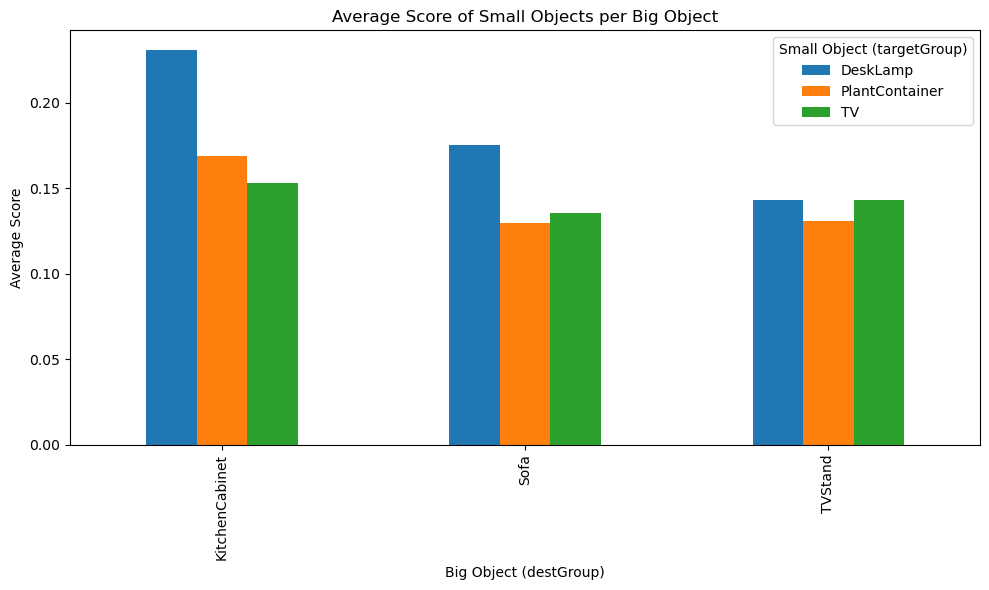

In [78]:
# Assuming df is ready and plot average scores
pivot = df.groupby(['destGroup', 'targetGroup'])['modelGroundProb'].median().unstack()
pivot.plot(kind='bar', figsize=(10,6))
plt.xlabel('Big Object (destGroup)')
plt.ylabel('Average Score')
plt.title('Average Score of Small Objects per Big Object')
plt.legend(title='Small Object (targetGroup)', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [74]:
# USING AVERAGE SCORE AS BASLINE FOR ALL IMAGES
# assume df is already loaded

# 1) baseline per (sceneId, targetGroup)
df["baselineProb"] = df.groupby(
    ["sceneId","targetGroup"]
)["modelGroundProb"].transform("mean")

# 2) change relative to that scene‑specific baseline
df["modelScoreChange"] = (
    (df["modelGroundProb"] - df["baselineProb"])
)

df
# Now each row’s baselineProb is the average of that small object
# across every big object in the same scene.
# pctChange is how much above/below that scene‑specific average it sits.

,Unnamed: 0.1,Unnamed: 0,unfilteredIdx,sceneId,dest,target,destGroup,targetGroup,modelGroundProb,modelOrigLabel,baselineProb,modelScoreChange
26,26,26,106,1ef2cfa1,SofaFactory(1320230).spawn_asset(6263973),DeskLampFactory(2387830).spawn_asset(6682535),Sofa,DeskLamp,0.1754,True,0.16210,0.01330
27,27,27,108,1ef2cfa1,TVStandFactory(3710974).spawn_asset(5037743),DeskLampFactory(2387830).spawn_asset(6682535),TVStand,DeskLamp,0.1488,True,0.16210,-0.01330
32,32,32,351,24fd346,SofaFactory(6937048).spawn_asset(9927896),DeskLampFactory(4212473).spawn_asset(6400528),Sofa,DeskLamp,0.1325,True,0.13490,-0.00240
33,33,33,361,24fd346,SofaFactory(6937048).spawn_asset(9927896),PlantContainerFactory(9914150).spawn_asset(390...,Sofa,PlantContainer,0.1295,True,0.13025,-0.00075
34,34,34,363,24fd346,SofaFactory(6937048).spawn_asset(9927896),TVFactory(4630574).spawn_asset(7323228),Sofa,TV,0.1336,True,0.13845,-0.00485
35,35,35,352,24fd346,TVStandFactory(5023041).spawn_asset(2778638),DeskLampFactory(4212473).spawn_asset(6400528),TVStand,DeskLamp,0.1373,True,0.13490,0.00240
36,36,36,362,24fd346,TVStandFactory(5023041).spawn_asset(2778638),PlantContainerFactory(9914150).spawn_asset(390...,TVStand,PlantContainer,0.1310,True,0.13025,0.00075
37,37,37,364,24fd346,TVStandFactory(5023041).spawn_asset(2778638),TVFactory(4630574).spawn_asset(7323228),TVStand,TV,0.1433,True,0.13845,0.00485
73,73,73,389,3529bef2,SofaFactory(3654285).spawn_asset(8358744),DeskLampFactory(3473261).spawn_asset(7201217),Sofa,DeskLamp,0.2479,True,0.24790,0.00000
180,180,180,408,777fb4f4,KitchenCabinetFactory(8533472).spawn_asset(654...,DeskLampFactory(6592385).spawn_asset(1283566),KitchenCabinet,DeskLamp,0.2100,True,0.17710,0.03290


In [79]:
# Alternative to above: Use object removed as baseline
# This the is rawData.csv from object removal experiment
raw_df = pd.read_csv( "/n/fs/obj-cv/experiment_project/experiments/objRemovalExp/dataFolder/livingroom97Data/rawData.csv" )
baselineProb_arr = []

# 2) Build the baselineProb list
baselineProb_arr = []

for _, row in df.iterrows():
    sceneId     = row["sceneId"]
    targetGroup = row["targetGroup"]

    # find any exact match for (sceneId, targetGroup)
    match = raw_df[
        (raw_df["sceneId"] == sceneId) &
        (raw_df["groupName"] == targetGroup)
    ]

    if not match.empty:
        # exists: take the removed modelGroundProb
        baselineProb_arr.append(match.iloc[0]["modelGroundProb"])
    else:
        # not exists: fall back to the first normGroundProb for that scene
        scene_match = raw_df[raw_df["sceneId"] == sceneId]
        if not scene_match.empty:
            baselineProb_arr.append(scene_match.iloc[0]["normGroundProb"])
        else:
            # no data at all for this scene — choose NaN or another default
            baselineProb_arr.append(float("nan"))
            # if sceneId != "205e85f0" and sceneId != "4866bdd6" and sceneId != "48d74f1c": # i know this one fails for dining room
            if sceneId != "4970ae14" and sceneId != "4d2a73d": # fails for bedroom
                raise Warning( sceneId, targetGroup )
                # pass

# 3) Attach back to your DataFrame
df["baselineProb"] = baselineProb_arr

# change relative to that scene‑specific baseline
df["modelScoreChange"] = (
    (df["modelGroundProb"] - df["baselineProb"])
)

df


,Unnamed: 0.1,Unnamed: 0,unfilteredIdx,sceneId,dest,target,destGroup,targetGroup,modelGroundProb,modelOrigLabel,baselineProb,modelScoreChange
26,26,26,106,1ef2cfa1,SofaFactory(1320230).spawn_asset(6263973),DeskLampFactory(2387830).spawn_asset(6682535),Sofa,DeskLamp,0.1754,True,0.1230,0.0524
27,27,27,108,1ef2cfa1,TVStandFactory(3710974).spawn_asset(5037743),DeskLampFactory(2387830).spawn_asset(6682535),TVStand,DeskLamp,0.1488,True,0.1230,0.0258
32,32,32,351,24fd346,SofaFactory(6937048).spawn_asset(9927896),DeskLampFactory(4212473).spawn_asset(6400528),Sofa,DeskLamp,0.1325,True,0.1272,0.0053
33,33,33,361,24fd346,SofaFactory(6937048).spawn_asset(9927896),PlantContainerFactory(9914150).spawn_asset(390...,Sofa,PlantContainer,0.1295,True,0.1272,0.0023
34,34,34,363,24fd346,SofaFactory(6937048).spawn_asset(9927896),TVFactory(4630574).spawn_asset(7323228),Sofa,TV,0.1336,True,0.1088,0.0248
35,35,35,352,24fd346,TVStandFactory(5023041).spawn_asset(2778638),DeskLampFactory(4212473).spawn_asset(6400528),TVStand,DeskLamp,0.1373,True,0.1272,0.0101
36,36,36,362,24fd346,TVStandFactory(5023041).spawn_asset(2778638),PlantContainerFactory(9914150).spawn_asset(390...,TVStand,PlantContainer,0.1310,True,0.1272,0.0038
37,37,37,364,24fd346,TVStandFactory(5023041).spawn_asset(2778638),TVFactory(4630574).spawn_asset(7323228),TVStand,TV,0.1433,True,0.1088,0.0345
73,73,73,389,3529bef2,SofaFactory(3654285).spawn_asset(8358744),DeskLampFactory(3473261).spawn_asset(7201217),Sofa,DeskLamp,0.2479,True,0.2765,-0.0286
180,180,180,408,777fb4f4,KitchenCabinetFactory(8533472).spawn_asset(654...,DeskLampFactory(6592385).spawn_asset(1283566),KitchenCabinet,DeskLamp,0.2100,True,0.1064,0.1036


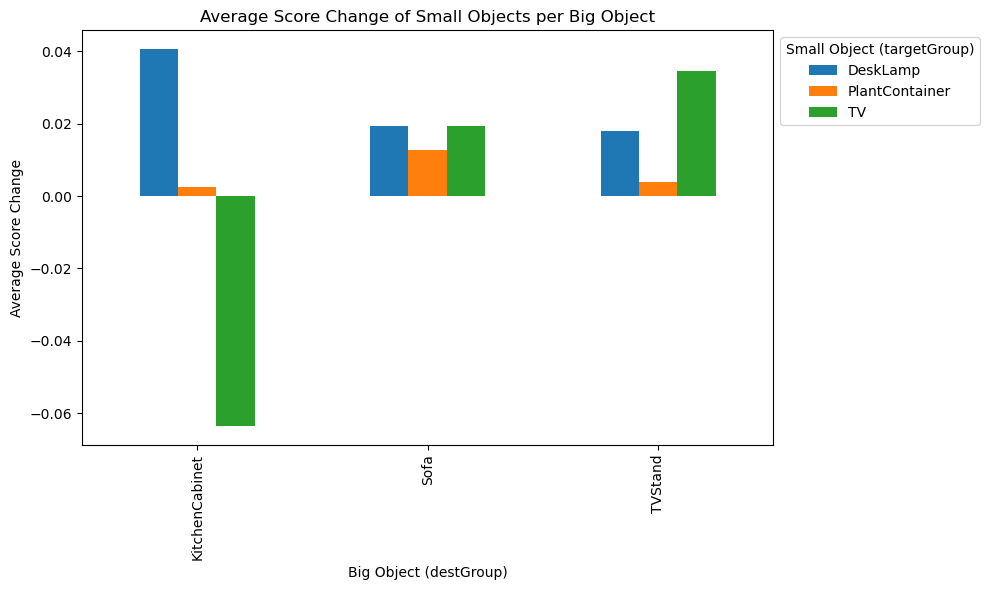

In [80]:
# Assuming df is ready
pivot = df.groupby(['destGroup', 'targetGroup'])['modelScoreChange'].mean().unstack()
pivot.plot(kind='bar', figsize=(10,6))
plt.xlabel('Big Object (destGroup)')
plt.ylabel('Average Score Change')
plt.title('Average Score Change of Small Objects per Big Object')
plt.legend(title='Small Object (targetGroup)', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

# Images to Data